# 꿈꾸는 인공지능 12강
* 특징 추출기 
  * 미리 훈련된 모델에서 데이터의 특징만 추출.
  * 추출한 특징을 작은 네트워크에 통과시켜 정답을 예측
  * 미리 추출된 특징은 파일로 저장 후 원할때 불러서 사용
  * 학습할 때 마다 계산 반복이 필요 없음 
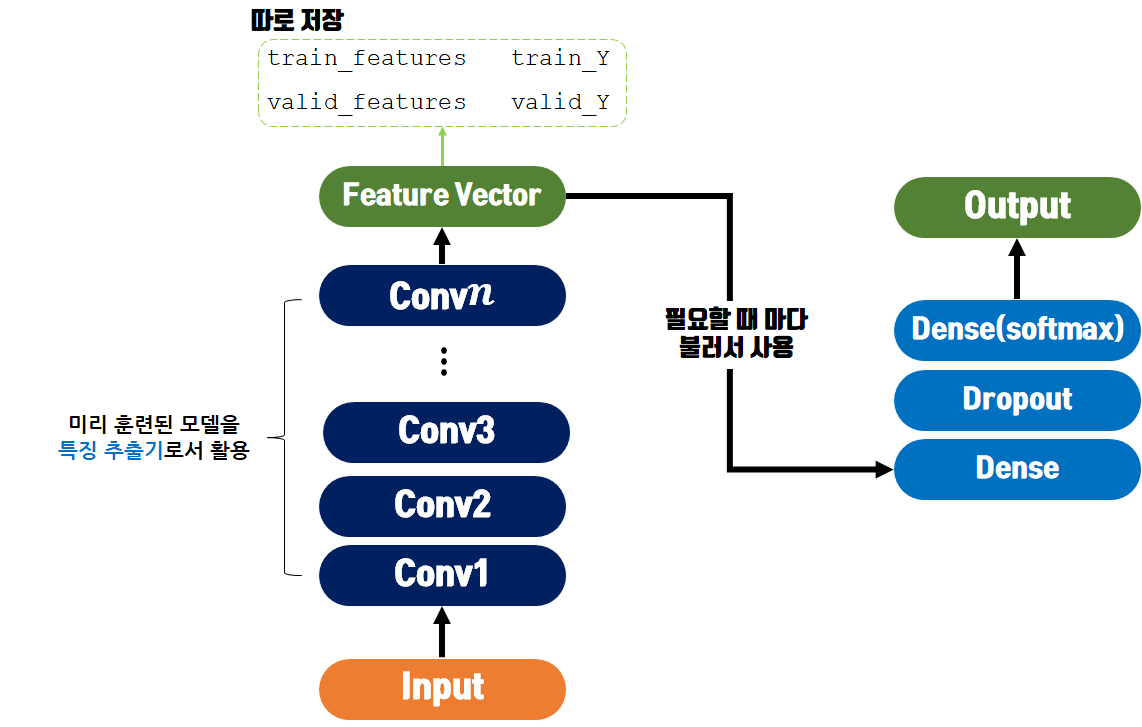


# 텐서플로우 및 기타 라이브러리 불러오기

In [ ]:
import tensorflow as tf
import pandas as pd
import numpy as np
import PIL.Image as Image
import matplotlib.pyplot as plt
import cv2

# Inception V3 불러오기
 * 2014년 구글이 ImageNet 대회를 위해 GoogLeNet 이라는 이름으로 발표
  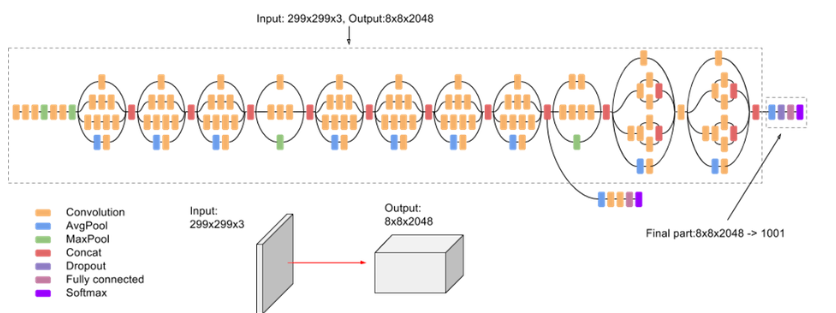

 * 참고문헌 : https://arxiv.org/pdf/1512.00567.pdf

# hub.KerasLayer() 사용법 : 
   * hub.KerasLayer() : 텐서플로우 허브에 올라와 있는 모델을 사용해 줄 수 있음
   - tf.keras()에서 사용가능한 레이어로 전환
   * Inception V3에서 마지막 Dense 레이어에 넘겨주는 출력의 크기는 2048,
   * 우리가 불러오는 특징 추출기는 '마지막 Dense 레이어' 를 포함하지 않기 때문에 output_shape=(2048, ) 로 출력크기를 지정


In [ ]:
import tensorflow_hub as hub

#특징 추출기 불러오기( 완전연결계층 X / input_shape 또한 따로 특정되지 않음 / 사전 훈련 x )
inception_url = 'https://tfhub.dev/google/tf2-preview/inception_v3/feature_vector/4'
feature_model = tf.keras.Sequential([
    hub.KerasLayer(inception_url, 
                   output_shape=(2048,), 
                   trainable=False)
])


# feature_model.build() 사용법: 
 * 신경망의 input_shape이 따로 특정되지 않았기 때문에 build()로 정의
  * [배치차원, 이미지의 높이, 너비, 차원] 

In [ ]:
feature_model.build([None, 299, 299, 3])
feature_model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
keras_layer (KerasLayer)     (None, 2048)              21802784  
Total params: 21,802,784
Trainable params: 0
Non-trainable params: 21,802,784
_________________________________________________________________


# ImageDataGenerator 활용을 위한 사전작업 
 * 새로운 폴더생성 
 * 이미지 복사본 생성 
 * os.path.exists('/content/train_sub/') : 이 경로의 존재여부에 따라 불리언(boolean)  반환
 

In [ ]:
tf.keras.utils.get_file('/content/labels.csv', 'http://bit.ly/2GDxsYS')
tf.keras.utils.get_file('/content/sample_submission.csv', 'http://bit.ly/2GGnMNd')
tf.keras.utils.get_file('/content/train.zip', 'http://bit.ly/31nIyel')
tf.keras.utils.get_file('/content/test.zip', 'http://bit.ly/2GHEsnO')

362848256/362841195 [==============================] - 9s 0us/step


'/content/test.zip'

In [ ]:
!unzip train.zip
!unzip test.zip

In [ ]:
label_text = pd.read_csv('labels.csv')
print(label_text.head(10))

                                 id               breed
0  000bec180eb18c7604dcecc8fe0dba07         boston_bull
1  001513dfcb2ffafc82cccf4d8bbaba97               dingo
2  001cdf01b096e06d78e9e5112d419397            pekinese
3  00214f311d5d2247d5dfe4fe24b2303d            bluetick
4  0021f9ceb3235effd7fcde7f7538ed62    golden_retriever
5  002211c81b498ef88e1b40b9abf84e1d  bedlington_terrier
6  00290d3e1fdd27226ba27a8ce248ce85  bedlington_terrier
7  002a283a315af96eaea0e28e7163b21b              borzoi
8  003df8b8a8b05244b1d920bb6cf451f9             basenji
9  0042188c895a2f14ef64a918ed9c7b64  scottish_deerhound


In [ ]:
import os
import shutil

#새로운 폴더 생성  
os.mkdir('/content/train_sub')

# 경로 생성  및 파일 복사
for i in range(len(label_text)):
  # 만약 /content/train_sub/label_text 가 없다면은 수행해라.  
    if os.path.exists('/content/train_sub/' + label_text.loc[i]['breed']) == False:
    #새롭게 만들어라 경로를 /content/train_sub/label_text 
        os.mkdir('/content/train_sub/' + label_text.loc[i]['breed'])
  # copy(복사할 대상, 경로)
  # 해당 경로(train_sub)를 만들고, 그 아래에 label_text의 각 데이터의 breed에 해당하는 하위 경로 만들고 해당 파일복사
    shutil.copy('/content/train/' + label_text.loc[i]['id'] + '.jpg', '/content/train_sub/' + label_text.loc[i]['breed'])

# ImageDataGenerator를 활용한 데이터셋 보강 및 분할 
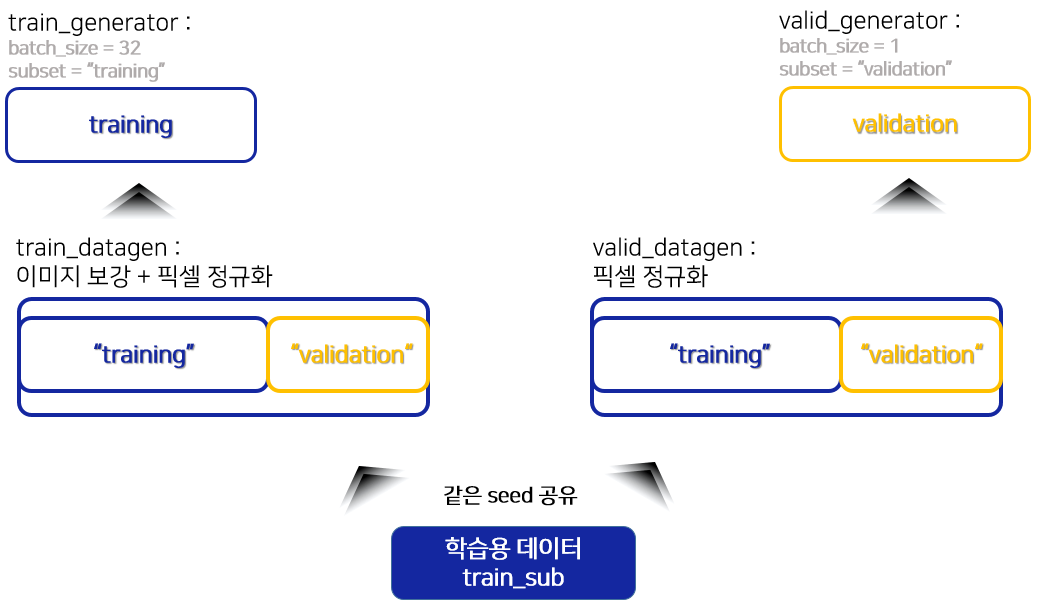

In [ ]:
from tensorflow.python.keras.preprocessing.image import ImageDataGenerator
from keras.applications.inception_resnet_v2 import preprocess_input

image_size = 299
batch_size = 32

# 학습 및 검증 데이터용 ImageDataGenerator 생성해 놓기 
train_datagen = ImageDataGenerator(rescale=1./255., 
                                   horizontal_flip = True, 
                                   shear_range = 0.2,
                                   zoom_range = 0.2,
                                   width_shift_range = 0.2,
                                   height_shift_range = 0.2,
                                   validation_split = 0.25)

#검증데이터는 정규화 외에 따로 조정 없음 
valid_datagen = ImageDataGenerator(rescale=1./255., 
                                   validation_split = 0.25)

#flow_from_directory()는 앞서 배운 flow()와 비슷, 단 경로를 통채로 가져올 수 있음 
train_generator = train_datagen.flow_from_directory(directory = '/content/train_sub', #저장 경로 
                                                    subset = 'train',   
                                                    batch_size = batch_size,
                                                    seed = 126,
                                                    shuffle = True,
                                                    class_mode = 'categorical',
                                                    target_size = (image_size,image_size))

valid_generator = valid_datagen.flow_from_directory(directory = '/content/train_sub',
                                                    subset = 'validation',
                                                    batch_size = 1,
                                                    seed = 126,
                                                    shuffle = True,
                                                    class_mode = 'categorical',
                                                    target_size = (image_size,image_size))


Found 7718 images belonging to 120 classes.
Found 2504 images belonging to 120 classes.


# 훈련 데이터를 특징 벡터로 변환 

######  **(23058, 2048)** 
######  **(23058, 120)** 
* 23058 = train의 (행)       
* 2048 = Inception V3에서 마지막 Dense 레이어에 넘겨주는 
출력의 크기는 2048 , 특징 벡터(열) 
* 120 = 학습 데이터의 라벨링 수 


* [가로, 세로, 채널]의 이미지가 마지막 레이어에 넘겨주는 [2048] 개의 실수로 변환
   - 2048 / (299 X 299 X 3) X 100 = 약 0.76 % 픽셀 감소 

In [ ]:
# 학습데이터의 3배정도 이미지가 보강되도록 한다.
import numpy as np

image_size = 299
batch_size = 32

batch_step = (7718 * 3) // batch_size #데이터 증폭 시켜 배치 스텝을 구해준다.(723회)
train_features = [] # 빈 리스트 생성 
train_Y = [] # 빈 리스트 생성 

for idx in range(batch_step): #스텝 만큼 반복
  if idx % 100 == 0: #만약 0 포함 100의 배수일때
    print(idx) #배치스텝 반환 (진행상황 표기)
  x, y = train_generator.next() #next()를 활용하여 train_generator에 담겨진 [[입력픽셀],[라벨링]] 을 x와 y에 담아 준다.   
  train_Y.extend(y) #append()와 비슷한 기능, list에 appending 수행
  
  # feature_model : 이미 학습이 완료된 특징 추출기 (우리가 불러옴)
  # 학습데이터 x 를 활용해서 feature_model을 통과시켜 특징 추출.
  feature = feature_model.predict(x)
  train_features.extend(feature)

#array 전환 
train_features = np.array(train_features)
train_Y = np.array(train_Y)

print(train_features.shape)
print(train_Y.shape)

0
100
200
300
400
500
600
700
(23084, 2048)
(23084, 120)


# 검증 데이터를 특징 벡터로 변환

In [ ]:
valid_features = [] # 빈 리스트 생성 
valid_Y = [] # 빈 리스트 생성 


for idx in range(valid_generator.n): ## valid_generator.n = 2504 (검증데이터의 수)
  if idx % 100 == 0: #만약 0 포함 100의 배수일때
    print(idx) #배치스텝 반환 (진행상황 표기)
  x, y = valid_generator.next() #next()를 활용하여 valid_generator에 담겨진 [[입력픽셀],[라벨링]] 을 x와 y에 담아 준다.   
  valid_Y.extend(y) #append()와 비슷한 기능, list에 appending 수행
  
  # feature_model : 이미 학습이 완료된 특징 추출기 (우리가 불러옴)
  # 학습데이터 x 를 활용해서 feature_model을 통과시켜 특징 추출.
  feature = feature_model.predict(x)
  valid_features.extend(feature)

#array 전환 
valid_features = np.array(valid_features)
valid_Y = np.array(valid_Y)

print(valid_features.shape)
print(valid_Y.shape)

0
100
200
300
400
500
600
700
800
900
1000
1100
1200
1300
1400
1500
1600
1700
1800
1900
2000
2100
2200
2300
2400
2500
(2504, 2048)
(2504, 120)


# 모델 설계 
# 컴파일 단계 
 * categorical_crossentropy : ONE-HOT 인코딩 
 * sparse_categorical_crossentropy : 희소행렬 
 * RMSprop : 기울기를 단순하게 사용하지 않고, 최신 기울기들이 더 크게 반영되도록 하는 기법.



In [ ]:
model = tf.keras.Sequential([
                             tf.keras.layers.Dense(256, activation= 'relu', input_shape = (2048,)),
                             tf.keras.layers.Dropout(0.5),
                             tf.keras.layers.Dense(120,activation='softmax')
])
model.compile(tf.optimizers.RMSprop(0.0001), 
              loss = 'categorical_crossentropy',
              metrics=['accuracy'])
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 256)               524544    
_________________________________________________________________
dropout (Dropout)            (None, 256)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 120)               30840     
Total params: 555,384
Trainable params: 555,384
Non-trainable params: 0
_________________________________________________________________


# 학습 설계 
 * validation_data 를 통해 직접 '검증 데이터의 특징 추출값'과 '라벨링 값'을 설정   

In [ ]:
history = model.fit(train_features, train_Y, 
                    validation_data=(valid_features, valid_Y),
                    epochs = 10,
                    batch_size = 32)

Epoch 1/10
721/721 [==============================] - 2s 2ms/step - loss: 2.8405 - accuracy: 0.4490 - val_loss: 0.9157 - val_accuracy: 0.8738
Epoch 2/10
721/721 [==============================] - 2s 2ms/step - loss: 0.9425 - accuracy: 0.7768 - val_loss: 0.4314 - val_accuracy: 0.8886
Epoch 3/10
721/721 [==============================] - 2s 2ms/step - loss: 0.6333 - accuracy: 0.8231 - val_loss: 0.3585 - val_accuracy: 0.8966
Epoch 4/10
721/721 [==============================] - 2s 2ms/step - loss: 0.5123 - accuracy: 0.8500 - val_loss: 0.3256 - val_accuracy: 0.9022
Epoch 5/10
721/721 [==============================] - 2s 2ms/step - loss: 0.4523 - accuracy: 0.8610 - val_loss: 0.3171 - val_accuracy: 0.8978
Epoch 6/10
721/721 [==============================] - 2s 2ms/step - loss: 0.4101 - accuracy: 0.8749 - val_loss: 0.3051 - val_accuracy: 0.8974
Epoch 7/10
721/721 [==============================] - 2s 2ms/step - loss: 0.3752 - accuracy: 0.8818 - val_loss: 0.3030 - val_accuracy: 0.9034
Epoch 

# 학습 및 검증데이터 결과 시각화 

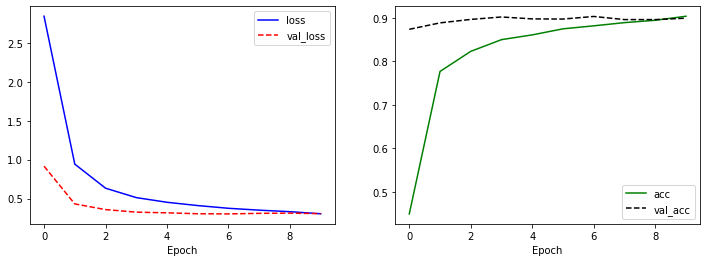

In [ ]:
import matplotlib.pyplot as plt
plt.figure(figsize = (12,4))

plt.subplot(1,2,1)
plt.plot(history.history['loss'], 'b-', label = 'loss')
plt.plot(history.history['val_loss'], 'r--', label = 'val_loss')
plt.xlabel('Epoch')
plt.legend()

plt.subplot(1,2,2)
plt.plot(history.history['accuracy'], 'g-', label = 'acc')
plt.plot(history.history['val_accuracy'], 'k--', label = 'val_acc')
plt.xlabel('Epoch')
plt.legend()

plt.show()

# 라벨링 텍스트 정렬

In [ ]:
#'breed'라는 속성값 안에 포함된 데이터 중 '유일 값'을 찾아 '리스트'로 전환하여 저장 
unique_Y = label_text['breed'].unique().tolist()
#sorted() : 알파벳 순으로 정렬
unique_sorted_Y = sorted(unique_Y)
print(unique_sorted_Y)

['affenpinscher', 'afghan_hound', 'african_hunting_dog', 'airedale', 'american_staffordshire_terrier', 'appenzeller', 'australian_terrier', 'basenji', 'basset', 'beagle', 'bedlington_terrier', 'bernese_mountain_dog', 'black-and-tan_coonhound', 'blenheim_spaniel', 'bloodhound', 'bluetick', 'border_collie', 'border_terrier', 'borzoi', 'boston_bull', 'bouvier_des_flandres', 'boxer', 'brabancon_griffon', 'briard', 'brittany_spaniel', 'bull_mastiff', 'cairn', 'cardigan', 'chesapeake_bay_retriever', 'chihuahua', 'chow', 'clumber', 'cocker_spaniel', 'collie', 'curly-coated_retriever', 'dandie_dinmont', 'dhole', 'dingo', 'doberman', 'english_foxhound', 'english_setter', 'english_springer', 'entlebucher', 'eskimo_dog', 'flat-coated_retriever', 'french_bulldog', 'german_shepherd', 'german_short-haired_pointer', 'giant_schnauzer', 'golden_retriever', 'gordon_setter', 'great_dane', 'great_pyrenees', 'greater_swiss_mountain_dog', 'groenendael', 'ibizan_hound', 'irish_setter', 'irish_terrier', 'iris

# Inception V3 특징 추출기 + 시퀀셜 모델을 활용한 TOP 5 예측 시각화 

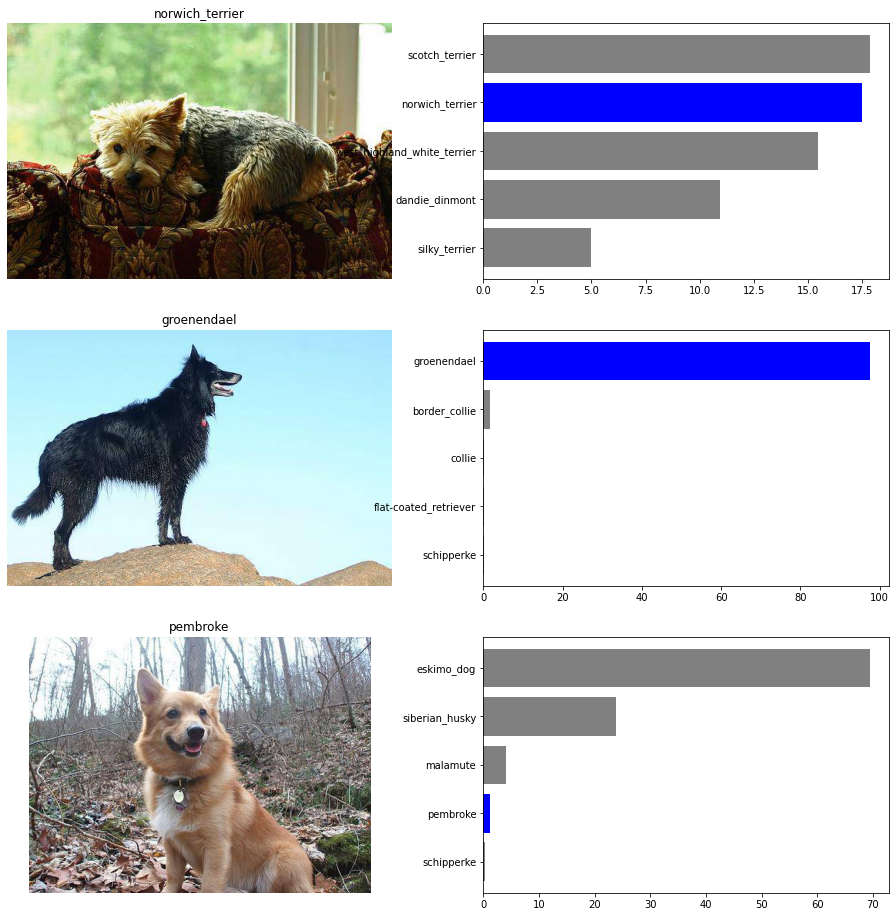

In [ ]:
import random
import cv2


plt.figure(figsize=(16,16))

for i in range(3): 
  image_path = random.choice(valid_generator.filepaths) # valid_generator.filepaths은 각 검증 데이터의 파일 경로를 반환
  #image_path → /content/train_sub/bluetick/0e79be614f12deb4f7cae18614b7391b.jpg

  #출력 범위 설정 
  plt.subplot(3,2,i*2+1)
  
  #검증데이터 출력 
  plt.imshow(plt.imread(image_path))
  
  # split('/')를 통해 나눠진 부분 중 3번째 획득
  real_y = image_path.split('/')[3]
  # real_y → bluetick 출력 
  
  #타이틀 출력 
  plt.title(real_y)
  plt.axis('off')
  #unique_sorted_Y 에 저장된 값을 바탕으로 real_y의 위치 값 할당 
  idx = unique_sorted_Y.index(real_y)
  # idx → ex) 81, ...  
 
  #예측값 표기
  plt.subplot(3,2,i * 2+2)
  img = cv2.imread(image_path)
  img = cv2.resize(img, dsize=(299,299))
  img = img / 255.0
  #차원 추가 (axis=0이 되면 1이 추가됨.(299,299,3)→(1,299,299,3))
  img = np.expand_dims(img, axis=0)
  
  #img를 Inception V3의 특징 추출기 feature_model을 활용하여 특징 벡터를 생성. 
  feature_vector = feature_model.predict(img)

  # 앞서 생성한 model 분류기를 통해 예측 수행
  prediction = model.predict(feature_vector)[0]
  
  #가장 높은 확률의 예측값을 5개 선출 
  #[::-1] Extended Slices 기법으로 내림차순으로 변경, [:5] 그 중 top 5개
  top_5_predict = prediction.argsort()[::-1][:5]
  #labels에 저장 
  labels = [unique_sorted_Y[index] for index in top_5_predict]
  color = ['gray'] * 5
  #예측 수행한 Top 5 값에 대하여 'blue' 으로 변경
  if idx in top_5_predict:
    color[top_5_predict.tolist().index(idx)] = 'blue'
  color = color[::-1]
  #가로 막대 그리기 
  plt.barh(range(5), prediction[top_5_predict][::-1] * 100, color = color)
  plt.yticks(range(5), labels[::-1])

# 도전! Kaggle! 다음기회에...

In [ ]:
!unzip test.zip

In [ ]:
import pandas as pd
submission = pd.read_csv('sample_submission.csv')
print(submission.head())
print()
print(submission.info())

                                 id  ...  yorkshire_terrier
0  000621fb3cbb32d8935728e48679680e  ...           0.008333
1  00102ee9d8eb90812350685311fe5890  ...           0.008333
2  0012a730dfa437f5f3613fb75efcd4ce  ...           0.008333
3  001510bc8570bbeee98c8d80c8a95ec1  ...           0.008333
4  001a5f3114548acdefa3d4da05474c2e  ...           0.008333

[5 rows x 121 columns]

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10357 entries, 0 to 10356
Columns: 121 entries, id to yorkshire_terrier
dtypes: float64(120), object(1)
memory usage: 9.6+ MB
None


# 하위 디렉터리 구조로 데이터 복사 

In [ ]:
import os
import shutil

os.mkdir('/content/test_sub/')
os.mkdir('/content/test_sub/unknown/')

for i in range(len(submission)):
    shutil.copy('/content/test/' + submission.loc[i]['id'] + '.jpg', '/content/test_sub/unknown/')

# ImageDataGenerator를 활용한 테스트 데이터 불러오기  

In [ ]:
from tensorflow.python.keras.preprocessing.image import ImageDataGenerator

test_datagen=ImageDataGenerator(rescale=1./255.)
test_generator=test_datagen.flow_from_directory(directory="/content/test_sub/",
                                                batch_size=1,
                                                seed=126,
                                                shuffle=False,
                                                target_size=(299, 299))


Found 10357 images belonging to 1 classes.


# testdata를 특징 벡터로 변환 

In [ ]:
test_features = []

for idx in range(test_generator.n):
  if idx % 100 == 0 :
    print(idx)

  x, _ = test_generator.next()
  feature = feature_model.predict(x)
  test_features.extend(feature)

test_features = np.array(test_features)
print(test_features.shape)

0
100
200
300
400
500
600
700
800
900
1000
1100
1200
1300
1400
1500
1600
1700
1800
1900
2000
2100
2200
2300
2400
2500
2600
2700
2800
2900
3000
3100
3200
3300
3400
3500
3600
3700
3800
3900
4000
4100
4200
4300
4400
4500
4600
4700
4800
4900
5000
5100
5200
5300
5400
5500
5600
5700
5800
5900
6000
6100
6200
6300
6400
6500
6600
6700
6800
6900
7000
7100
7200
7300
7400
7500
7600
7700
7800
7900
8000
8100
8200
8300
8400
8500
8600
8700
8800
8900
9000
9100
9200
9300
9400
9500
9600
9700
9800
9900
10000
10100
10200
10300
(10357, 2048)


# 예측 수행
* 예측한 결과를 test_Y로 저장

In [ ]:
test_Y = model.predict(test_features, verbose = 1)

324/324 [==============================] - 0s 975us/step


# 테스트결과를 submission으로 옮기기

In [ ]:
for i in range(len(test_Y)): # len(test_Y) : 10357
  for j in range(len(test_Y[i])): #len(test_Y[i]) : 120
    breed_column = unique_sorted_Y[j] # unique_sorted_Y[j] : 'afghan_hound'
    submission.loc[i, breed_column] = test_Y[i,j]

print(submission.head())

                                 id  ...  yorkshire_terrier
0  000621fb3cbb32d8935728e48679680e  ...       2.121418e-06
1  00102ee9d8eb90812350685311fe5890  ...       2.266620e-08
2  0012a730dfa437f5f3613fb75efcd4ce  ...       1.651476e-05
3  001510bc8570bbeee98c8d80c8a95ec1  ...       2.864283e-07
4  001a5f3114548acdefa3d4da05474c2e  ...       1.173029e-04

[5 rows x 121 columns]


In [ ]:
print(submission.iloc[:5, :5])

                                 id  ...      airedale
0  000621fb3cbb32d8935728e48679680e  ...  2.032063e-07
1  00102ee9d8eb90812350685311fe5890  ...  3.699176e-08
2  0012a730dfa437f5f3613fb75efcd4ce  ...  5.202125e-06
3  001510bc8570bbeee98c8d80c8a95ec1  ...  3.906170e-08
4  001a5f3114548acdefa3d4da05474c2e  ...  1.106118e-07

[5 rows x 5 columns]


# 결과 다운로드 

In [ ]:
submission.to_csv('dogbreed_submission_inceptionV3_epoch10_299.csv', index = False)